<a href="https://colab.research.google.com/github/naemililia/masterthesis/blob/main/train_contrastive_learning_eurosat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I am taking the dataloaders etc from my pretext task

the contrastive learning code for simclr I am taking from here:
https://medium.com/the-owl/simclr-in-pytorch-5f290cb11dd7

## 0. Installations and imports

In [ ]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 48.7 MB/s eta 0:00:00


In [ ]:
# connect drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# create a folder for model checkpoints

%cd /home
!sudo mkdir checkpoints

/home


In [ ]:
import rasterio
import numpy as np
import pandas as pd
import shutil, time, requests, copy
from sklearn.model_selection import train_test_split
import os
import csv
from PIL import Image
from scipy.ndimage import zoom
import torch
import random
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
from matplotlib import pyplot as plt
#import segmentation_models_pytorch as smp
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional as F
from tqdm.notebook import tqdm
from IPython.display import clear_output
from IPython.display import display

## 2. Prepare the dataloaders

In [ ]:
# the labels are saved on my google drive
BUILT_path_eurosat = '/content/drive/MyDrive/eurosat_BUILT'
LC_path_eurosat = '/content/drive/MyDrive/eurosat_LC'


test_train_images_path = '/content/drive/MyDrive/EuroSAT_MS_test'
train_images_path = '/content/drive/MyDrive/EuroSAT_MS'





In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/EuroSAT_MS/pretext_train_data.csv', header=None)
train_data

,0,1
0,HerbaceousVegetation/HerbaceousVegetation_1170...,HerbaceousVegetation_1170_label.npy
1,Residential/Residential_59.tif,Residential_59_label.npy
2,River/River_1162.tif,River_1162_label.npy
3,HerbaceousVegetation/HerbaceousVegetation_1205...,HerbaceousVegetation_1205_label.npy
4,AnnualCrop/AnnualCrop_75.tif,AnnualCrop_75_label.npy
...,...,...
7123,HerbaceousVegetation/HerbaceousVegetation_151.tif,HerbaceousVegetation_151_label.npy
7124,PermanentCrop/PermanentCrop_1087.tif,PermanentCrop_1087_label.npy
7125,Industrial/Industrial_65.tif,Industrial_65_label.npy
7126,HerbaceousVegetation/HerbaceousVegetation_404.tif,HerbaceousVegetation_404_label.npy


In [ ]:
val_data = pd.read_csv('/content/drive/MyDrive/EuroSAT_MS/pretext_val_data.csv', header=None)
val_data

,0,1
0,Forest/Forest_913.tif,Forest_913_label.npy
1,Highway/Highway_1488.tif,Highway_1488_label.npy
2,SeaLake/SeaLake_1598.tif,SeaLake_1598_label.npy
3,HerbaceousVegetation/HerbaceousVegetation_2796...,HerbaceousVegetation_2796_label.npy
4,Highway/Highway_1127.tif,Highway_1127_label.npy
...,...,...
1777,HerbaceousVegetation/HerbaceousVegetation_179.tif,HerbaceousVegetation_179_label.npy
1778,SeaLake/SeaLake_1060.tif,SeaLake_1060_label.npy
1779,Pasture/Pasture_1008.tif,Pasture_1008_label.npy
1780,Forest/Forest_1329.tif,Forest_1329_label.npy


In [ ]:
# functions needed for the loading of the data

def getArrFlood(fname):
    """Load .tif data into array"""
    return rasterio.open(fname).read()

def iloader(path):
    image = np.asarray((io.imread(path))/5000,dtype='float32')
    return image.transpose(2,0,1)

def download_data_from_list_singlelabel(l):
    """
    Download and prepare training data from file list.

    Gets training_list from load_flood_train_data
    downloads/reads each of the files (image and the 1 label) for each row
    returns a list of tuples, where teh first entry is the array of the image, and the second is a list of the label array
    """
    i = 0
    flood_data = []
    for (im_fname, mask_fname1) in l:
        if os.path.exists(mask_fname1):
          # Load the satelite image with rasterio (it is a .tif)
          arr_x = iloader(im_fname)

          # Load masks from different roots using numpy
          arr_y1 = np.load(mask_fname1)

          if i % 100 == 0:
            print(im_fname)
          i += 1

          flood_data.append((arr_x, [arr_y1]))

    return flood_data

def load_flood_train_data_multilabel(input_root, label_root_1):
    """
    Load training data including single label defined above in step 2 from specified roots.

    creates training_list that it hands over to next function: download_flood_water_data_from_list

    training_list has length of the training dataset csv + 1 (because it also creates path for the header, this will be discarded later on as it will not pass the .is_file() check
    each entry of the training_list is a tuple with 2 paths: image_path, label_path1
    """
    fname = "/content/drive/MyDrive/EuroSAT_MS/pretext_train_data.csv" # train_data_subset / test_train_filenames / S1weak_train_filenames_final
    training_files = []
    with open(fname) as f:
        for line in csv.reader(f):
            image_path = os.path.join(input_root, line[0])
            label_path1 = os.path.join(label_root_1, line[1])
            training_files.append((image_path, label_path1))

    return  download_data_from_list_singlelabel(training_files)

def load_flood_valid_data_multilabel(input_root, label_root_1):
    """
    Load validation data including label from specified roots.

    creates validation_list that it hands over to next function: download_flood_water_data_from_list

    validation_list has length of the validation dataset csv + 1 (because it also creates path for the header, this will be discarded later on as it will not pass the .is_file() check
    each entry of the validation_list is a tuple with 2 paths: image_path, label_path1
    """
    fname = "/content/drive/MyDrive/EuroSAT_MS/pretext_val_data.csv" # val_data_subset / test_val_filenames / S1weak_val_filenames_final
    val_files = []
    with open(fname) as f:
        for line in csv.reader(f):
            image_path = os.path.join(input_root, line[0])
            label_path1 = os.path.join(label_root_1, line[1])
            val_files.append((image_path, label_path1))

    return download_data_from_list_singlelabel(val_files)

In [ ]:
# functions needed for the processing of the labels

quantiles_built = [1.000e+00, 9.200e+01, 7.140e+02, 1.532e+03, 2.165e+03, 6.375e+03]

def make_BUILT_categorical(array_label):
  categorical_label = np.digitize(array_label, quantiles_built, right=True)

  categorical_label = categorical_label.astype(np.uint8)
  return categorical_label

# possible LC label values
possible_label_vals = [20,  30,  40,  50,  60,  70,  80,  90, 100, 111, 114, 115, 116,
       121, 124, 125, 126, 200]

# create a mapping dictioanry
label_to_class_id = {label: idx for idx, label in enumerate(possible_label_vals)}
vectorized_map = np.vectorize(label_to_class_id.get, otypes=[np.uint32])

def class_id_transformation_LC(array_label):
  """
  Transforms all LC label values to class_id values. The class IDs are defined above
  """
  return vectorized_map(array_label)

def resize_the_label_for_eurosat(array_label):
  """
  Resizes each label to the Senfloods image size of 512 x 512.
  BUILT & POP are resized with order = 1, a liniear interpolation
  LC is resized with order = 0, a nearest neighbor technique
  """
  original_shape = array_label.shape

  new_shape = (64, 64) # this is a senfloods specific function

  zoom_factors = [n / o for n, o in zip(new_shape, original_shape)]

  resized_label = zoom(array_label, zoom_factors, order = 0)

  return resized_label

In [ ]:
# the actual processing function for training data

def processAndAugmentMultipleLabels(data):
  """
  Preprocessing of training data (images and labels).

  Labels are scaled and resized.

  Random cropping to 256 x 256 and horizontal & vertical flipping of images & labels.

  Normalization of images with mean and standard deviation.

  Stacking of tensor image channels (2, 256, 256) and tensor labels (2, 256, 256)
  """
  (x, ys) = data
  im = x.copy() # (13,64,64), array
  labels = [y.copy() for y in ys] # list of 1 array, shape 6,10
  # # depening on AUXILIARY-DATASOURCE do different preprocessing
  # # hier findet label processing statt

  if AUXILIARY_DATASOURCE == 'BUILT':
    #labels[0] = log_scale_label(labels[0])
    #labels[0] = min_max_scale_BUILT(labels[0])
    labels[0] = make_BUILT_categorical(labels[0])
    labels[0] = resize_the_label_for_eurosat(labels[0])
  elif AUXILIARY_DATASOURCE == 'LC':
    labels[0] = class_id_transformation_LC(labels[0])
    labels[0] = resize_the_label_for_eurosat(labels[0]) # jetzt shape 64,64

  # Convert to PIL for easier transforms
  im1 = Image.fromarray(im[0])
  im2 = Image.fromarray(im[1])
  im3 = Image.fromarray(im[2])
  im4 = Image.fromarray(im[3])
  im5 = Image.fromarray(im[4])
  im6 = Image.fromarray(im[5])
  im7 = Image.fromarray(im[6])
  im8 = Image.fromarray(im[7])
  im9 = Image.fromarray(im[8])
  im10 = Image.fromarray(im[9])
  im11 = Image.fromarray(im[10])
  im12 = Image.fromarray(im[11])
  im13 = Image.fromarray(im[12])
  labels = [Image.fromarray(label.squeeze()) for label in labels]

  # # do the random rotation (but the same one to all)
  # random_int = random.randint(-3,3)
  # angle = random_int * 90

  # im1 = im1.rotate(angle)
  # im2 = im2.rotate(angle)
  # im3 = im3.rotate(angle)
  # im4 = im4.rotate(angle)
  # im5 = im5.rotate(angle)
  # im6 = im6.rotate(angle)
  # im7 = im7.rotate(angle)
  # im8 = im8.rotate(angle)
  # im9 = im9.rotate(angle)
  # im10 = im10.rotate(angle)
  # im11 = im11.rotate(angle)
  # im12 = im12.rotate(angle)
  # im13 = im13.rotate(angle)


  # if random.random() > 0.5:
  #     im1 = F.hflip(im1)
  #     im2 = F.hflip(im2)
  #     im3 = F.hflip(im3)
  #     im4 = F.hflip(im4)
  #     im5 = F.hflip(im5)
  #     im6 = F.hflip(im6)
  #     im7 = F.hflip(im7)
  #     im8 = F.hflip(im8)
  #     im9 = F.hflip(im9)
  #     im10 = F.hflip(im10)
  #     im11 = F.hflip(im11)
  #     im12 = F.hflip(im12)
  #     im13 = F.hflip(im13)
  #     labels = [F.hflip(label) for label in labels]
  # if random.random() > 0.5:
  #     im1 = F.vflip(im1)
  #     im2 = F.vflip(im2)
  #     im3 = F.vflip(im3)
  #     im4 = F.vflip(im4)
  #     im5 = F.vflip(im5)
  #     im6 = F.vflip(im6)
  #     im7 = F.vflip(im7)
  #     im8 = F.vflip(im8)
  #     im9 = F.vflip(im9)
  #     im10 = F.vflip(im10)
  #     im11 = F.vflip(im11)
  #     im12 = F.vflip(im12)
  #     im13 = F.vflip(im13)
  #     labels = [F.vflip(label) for label in labels]

  norm = transforms.Normalize([0.2703, 0.2232, 0.2084, 0.1894, 0.2401, 0.4013, 0.4757, 0.4612, 0.1468,
          0.0024, 0.3646, 0.2237, 0.5209], [0.0484, 0.0663, 0.0787, 0.1184, 0.1126, 0.1717, 0.2170, 0.2235, 0.0811,
          0.0009, 0.2001, 0.1517, 0.2461])
  im = torch.stack([transforms.ToTensor()(im1).squeeze(),
                    transforms.ToTensor()(im2).squeeze(),
                    transforms.ToTensor()(im3).squeeze(),
                    transforms.ToTensor()(im4).squeeze(),
                    transforms.ToTensor()(im5).squeeze(),
                    transforms.ToTensor()(im6).squeeze(),
                    transforms.ToTensor()(im7).squeeze(),
                    transforms.ToTensor()(im8).squeeze(),
                    transforms.ToTensor()(im9).squeeze(),
                    transforms.ToTensor()(im10).squeeze(),
                    transforms.ToTensor()(im11).squeeze(),
                    transforms.ToTensor()(im12).squeeze(),
                    transforms.ToTensor()(im13).squeeze(),
                    ]) # tensor of size (13, 64, 64) (or 256x256 if we crop), still same values

  #im = CustomToTensor(im) # tensor of size (2, 512, 512) (or 256x256 if we crop), still same values
  im = norm(im)
  labels = [torch.tensor(np.array(label)) for label in labels] # hier das , dtype=torch.long würde alles zu ints machen --> dann verliert aber auch built und pop jede information
  labels = torch.stack(labels) # torch.size(1, 64, 64)

  return im, labels

In [ ]:
# the processing function for validation data (similar to training processing)
# there is a different version of this in the train_pretext_prep file

def processTestImMultipleLabels_likeTrain(data):
  """
  Preprocessing of validation data (images and labels).

  Labels are scaled and resized.

  Non-random cropping to the middle 256 x 256 image.

  No random flipping either

  Normalization of images with mean and standard deviation of training data.

  Stacking of tensor image channels (2, 256, 256) and tensor labels (3, 256, 256)
  """
  (x,ys) = data
  im = x.copy() # (13,64,64), array
  labels = [y.copy() for y in ys] # list of 1 array, shape 6,10
  # # depening on AUXILIARY-DATASOURCE do different preprocessing
  # # hier findet label processing statt

  if AUXILIARY_DATASOURCE == 'BUILT':
    #labels[0] = log_scale_label(labels[0])
    #labels[0] = min_max_scale_BUILT(labels[0])
    labels[0] = make_BUILT_categorical(labels[0])
    labels[0] = resize_the_label_for_eurosat(labels[0])
  elif AUXILIARY_DATASOURCE == 'LC':
    labels[0] = class_id_transformation_LC(labels[0])
    labels[0] = resize_the_label_for_eurosat(labels[0]) # jetzt shape 64,64

  # Convert to PIL for easier transforms
  im1 = Image.fromarray(im[0])
  im2 = Image.fromarray(im[1])
  im3 = Image.fromarray(im[2])
  im4 = Image.fromarray(im[3])
  im5 = Image.fromarray(im[4])
  im6 = Image.fromarray(im[5])
  im7 = Image.fromarray(im[6])
  im8 = Image.fromarray(im[7])
  im9 = Image.fromarray(im[8])
  im10 = Image.fromarray(im[9])
  im11 = Image.fromarray(im[10])
  im12 = Image.fromarray(im[11])
  im13 = Image.fromarray(im[12])
  labels = [Image.fromarray(label.squeeze()) for label in labels]

  norm = transforms.Normalize([0.2703, 0.2232, 0.2084, 0.1894, 0.2401, 0.4013, 0.4757, 0.4612, 0.1468,
          0.0024, 0.3646, 0.2237, 0.5209], [0.0484, 0.0663, 0.0787, 0.1184, 0.1126, 0.1717, 0.2170, 0.2235, 0.0811,
          0.0009, 0.2001, 0.1517, 0.2461])
  im = torch.stack([transforms.ToTensor()(im1).squeeze(),
                    transforms.ToTensor()(im2).squeeze(),
                    transforms.ToTensor()(im3).squeeze(),
                    transforms.ToTensor()(im4).squeeze(),
                    transforms.ToTensor()(im5).squeeze(),
                    transforms.ToTensor()(im6).squeeze(),
                    transforms.ToTensor()(im7).squeeze(),
                    transforms.ToTensor()(im8).squeeze(),
                    transforms.ToTensor()(im9).squeeze(),
                    transforms.ToTensor()(im10).squeeze(),
                    transforms.ToTensor()(im11).squeeze(),
                    transforms.ToTensor()(im12).squeeze(),
                    transforms.ToTensor()(im13).squeeze(),
                    ]) # tensor of size (13, 64, 64) (or 256x256 if we crop), still same values

  #im = CustomToTensor(im) # tensor of size (2, 512, 512) (or 256x256 if we crop), still same values
  im = norm(im)
  labels = [torch.tensor(np.array(label)) for label in labels] # hier das , dtype=torch.long würde alles zu ints machen --> dann verliert aber auch built und pop jede information
  labels = torch.stack(labels) # torch.size(1, 64, 64)

  return im, labels

In [ ]:
# the dataset class i am using
class InMemoryDataset(torch.utils.data.Dataset):

  def __init__(self, data_list, preprocess_func):
    self.data_list = data_list
    self.preprocess_func = preprocess_func

  def __getitem__(self, i):
    return self.preprocess_func(self.data_list[i])

  def __len__(self):
    return len(self.data_list)

In [ ]:
AUXILIARY_DATASOURCE = 'LC' # / 'LC'

In [ ]:
# creating the dataloaders
from skimage import io
train_data = load_flood_train_data_multilabel(train_images_path, LC_path_eurosat) # test_train_images_path, path_to_data
train_dataset = InMemoryDataset(train_data, processAndAugmentMultipleLabels)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True, sampler=None,
                  batch_sampler=None, num_workers=0, collate_fn=None,
                  pin_memory=True, drop_last=True, timeout=0,
                  worker_init_fn=None)

/content/drive/MyDrive/EuroSAT_MS/HerbaceousVegetation/HerbaceousVegetation_1170.tif
/content/drive/MyDrive/EuroSAT_MS/HerbaceousVegetation/HerbaceousVegetation_2931.tif
/content/drive/MyDrive/EuroSAT_MS/Highway/Highway_1642.tif
/content/drive/MyDrive/EuroSAT_MS/Residential/Residential_2519.tif
/content/drive/MyDrive/EuroSAT_MS/Highway/Highway_1340.tif
/content/drive/MyDrive/EuroSAT_MS/HerbaceousVegetation/HerbaceousVegetation_244.tif
/content/drive/MyDrive/EuroSAT_MS/Forest/Forest_1446.tif
/content/drive/MyDrive/EuroSAT_MS/Residential/Residential_1912.tif
/content/drive/MyDrive/EuroSAT_MS/River/River_510.tif
/content/drive/MyDrive/EuroSAT_MS/Forest/Forest_2576.tif
/content/drive/MyDrive/EuroSAT_MS/Residential/Residential_1988.tif
/content/drive/MyDrive/EuroSAT_MS/River/River_1956.tif
/content/drive/MyDrive/EuroSAT_MS/Residential/Residential_178.tif
/content/drive/MyDrive/EuroSAT_MS/SeaLake/SeaLake_35.tif
/content/drive/MyDrive/EuroSAT_MS/PermanentCrop/PermanentCrop_1301.tif
/content/d

In [ ]:
valid_data = load_flood_valid_data_multilabel(train_images_path, LC_path_eurosat) # test_val_images_path, path_to_data
valid_dataset = InMemoryDataset(valid_data, processTestImMultipleLabels_likeTrain)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=256, shuffle=True, sampler=None,
                  batch_sampler=None, num_workers=0, #collate_fn=lambda x: (torch.cat([a[0] for a in x], 0), torch.cat([a[1] for a in x], 0)),
                  pin_memory=True, drop_last=True, timeout=0,
                  worker_init_fn=None)

/content/drive/MyDrive/EuroSAT_MS/Forest/Forest_913.tif
/content/drive/MyDrive/EuroSAT_MS/Pasture/Pasture_77.tif
/content/drive/MyDrive/EuroSAT_MS/Forest/Forest_1345.tif
/content/drive/MyDrive/EuroSAT_MS/Residential/Residential_1198.tif
/content/drive/MyDrive/EuroSAT_MS/Industrial/Industrial_1142.tif
/content/drive/MyDrive/EuroSAT_MS/AnnualCrop/AnnualCrop_45.tif
/content/drive/MyDrive/EuroSAT_MS/HerbaceousVegetation/HerbaceousVegetation_2030.tif
/content/drive/MyDrive/EuroSAT_MS/SeaLake/SeaLake_1816.tif
/content/drive/MyDrive/EuroSAT_MS/Industrial/Industrial_476.tif
/content/drive/MyDrive/EuroSAT_MS/Highway/Highway_575.tif
/content/drive/MyDrive/EuroSAT_MS/Forest/Forest_533.tif
/content/drive/MyDrive/EuroSAT_MS/AnnualCrop/AnnualCrop_332.tif
/content/drive/MyDrive/EuroSAT_MS/HerbaceousVegetation/HerbaceousVegetation_1682.tif
/content/drive/MyDrive/EuroSAT_MS/Industrial/Industrial_1395.tif
/content/drive/MyDrive/EuroSAT_MS/Residential/Residential_1420.tif
/content/drive/MyDrive/EuroSAT_M

## 3. Define the network, loss function & optimizer

SimCLR

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class ProjectionHead(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ProjectionHead, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 512), # 512 ist eine intermediate dimension um etwas komplexere representations zu lernen
            nn.ReLU(),
            nn.Linear(512, output_dim)
        )

    def forward(self, x):
        return self.fc(x)

class TwoStrandModel(nn.Module):
    def __init__(self):
        super(TwoStrandModel, self).__init__()
        # Initialize ResNet-18 models, each input type gets its own encoder (but they start out to be the same one)
        self.encoder_im1 = self.create_encoder(num_input_channels=13)  # for EuroSAT
        self.encoder_built = self.create_encoder(num_input_channels=1) # for BUILT or POP (might need a new model for LC, but actually not, because all teh classes are in the one channel)

        # Dimension of the ResNet-50 output before the fully connected layer
        feature_dim = 512 # 512 for resnet-18, 2048 for resnet50

        # Projection heads
        self.projection_im1 = ProjectionHead(input_dim=feature_dim, output_dim=128) # Jain, Wilson also use 128
        self.projection_built = ProjectionHead(input_dim=feature_dim, output_dim=128) # Jain, Wilson also use 128

    def create_encoder(self, num_input_channels):
        encoder = models.resnet18(weights='IMAGENET1K_V1') # pretrained on Imagenet might have a good effect and could counteract our single GPU disadvantage (der medium article lässt hoffen)
        encoder.conv1 = nn.Conv2d(num_input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # Remove the final fully connected layer
        encoder.fc = nn.Identity()
        return encoder

    def forward(self, im1, built):

        if built.dim() == 3 and built.shape[1] != 1:
            built = built.unsqueeze(1)  # Add a channel dimension

        # Pass inputs through their respective encoders
        features_im1 = self.encoder_im1(im1)
        features_built = self.encoder_built(built)

        # Pass through projection heads
        projected_im1 = self.projection_im1(features_im1)
        projected_built = self.projection_built(features_built)

        return projected_im1, projected_built


# # Example usage
# model = TwoStrandModel()
# criterion = ContrastiveLoss()

# # Model forward pass
# projected_im1, projected_built = model(im1, built)

# # Compute loss
# loss = criterion(projected_im1, projected_built)
# print('Loss:', loss.item())


In [ ]:
net = TwoStrandModel()

##Loss function



In [ ]:
# loss acc. to medium article
class SimCLR_Loss(nn.Module):
    def __init__(self, batch_size, temperature):
        super().__init__()
        self.batch_size = batch_size
        self.temperature = temperature

        # this is supposed to identify positive pairs
        self.mask = self.mask_correlated_samples(batch_size)

        # chatgpt: 'This sets up the cross-entropy loss for comparing the logits from concatenated positive and negative sample similarities against labels that are all zeros (indicating the first class is the correct class for all positive samples).'
        self.criterion = nn.CrossEntropyLoss(reduction="sum")


        self.similarity_f = nn.CosineSimilarity(dim=2)

    def mask_correlated_samples(self, batch_size):
        # we have N entries in a batch, and we have two views of the same location: SAR and the aux info
        N = 2 * batch_size

        # chatgpt: Creates an N x N mask initialized to True, to later exclude specific pairs from being considered as negative samples.
        mask = torch.ones((N, N), dtype=bool)

        # chatgpt: Sets the diagonal elements of the mask to False (0 in a boolean context), ensuring that each example is not compared with itself.
        mask = mask.fill_diagonal_(0)

        # These lines set the mask to False for each pair of correlated samples (i.e., each original and its augmented version), ensuring they are not considered as negative pairs.
        for i in range(batch_size):
            mask[i, batch_size + i] = 0
            mask[batch_size + i, i] = 0

        return mask

    def forward(self, z_i, z_j):

        N = 2 * self.batch_size

        # chatgpt: results in 2N total embeddings
        z = torch.cat((z_i, z_j), dim=0)

        # chaptgpt: Calculates the cosine similarity matrix for all pairs of embeddings, scaled by the temperature. unsqueeze is used to make the tensors compatible for pairwise similarity computation.
        sim = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature

        # chatgpt: Extracts the similarities of correlated (positive) pairs z_i to z_j and z_j to z_i from the similarity matrix.
        sim_i_j = torch.diag(sim, self.batch_size)
        sim_j_i = torch.diag(sim, -self.batch_size)

        # We have 2N samples, but with Distributed training every GPU gets N examples too, resulting in: 2xNxN
        # chatgpt: Concatenates the similarities of positive pairs and reshapes them for compatibility with the loss function.
        positive_samples = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)

        # chatgpt: Selects and reshapes the similarities of negative pairs as per the mask.
        negative_samples = sim[self.mask].reshape(N, -1)

        #SIMCLR

        # chatgpt: Creates labels, all set to 0, corresponding to the index of positive samples in concatenated logits. It ensures the labels are on the same device as the embeddings.
        labels = torch.from_numpy(np.array([0]*N)).reshape(-1).to(positive_samples.device).long() #.float()

        # chatgpt: Concatenates the positive samples with the negative samples to form the logits.
        logits = torch.cat((positive_samples, negative_samples), dim=1)

        # chatgpt: Calculates the cross-entropy loss and normalizes it by the number of pairs (N).
        loss = self.criterion(logits, labels)
        loss /= N

        return loss

In [ ]:
criterion = SimCLR_Loss(batch_size=256, temperature=0.5)

#### Optimizer

the paper uses LARS optimizer, because it is good at handling the very huge batch sizes.

Now with rather small batch sizes of 128, it might be overkill and i could also go with Adam optimizer instead?

In [ ]:
# # optimizer:


# from torch.optim.optimizer import Optimizer, required
# import re

# # chatgpt: eeta scales learning rate during trust ratio computation
# EETA_DEFAULT = 0.001


# class LARS(Optimizer):
#     """
#     Layer-wise Adaptive Rate Scaling for large batch training.
#     Introduced by "Large Batch Training of Convolutional Networks" by Y. You,
#     I. Gitman, and B. Ginsburg. (https://arxiv.org/abs/1708.03888)
#     """

#     def __init__(
#         self,
#         params,
#         lr=required,
#         momentum=0.9,
#         use_nesterov=False,
#         weight_decay=0.0, # L2 regularization factor
#         exclude_from_weight_decay=None,
#         exclude_from_layer_adaptation=None,
#         classic_momentum=True,
#         eeta=EETA_DEFAULT,
#     ):
#         """Constructs a LARSOptimizer.
#         Args:
#         lr: A `float` for learning rate.
#         momentum: A `float` for momentum.
#         use_nesterov: A 'Boolean' for whether to use nesterov momentum.
#         weight_decay: A `float` for weight decay.
#         exclude_from_weight_decay: A list of `string` for variable screening, if
#             any of the string appears in a variable's name, the variable will be
#             excluded for computing weight decay. For example, one could specify
#             the list like ['batch_normalization', 'bias'] to exclude BN and bias
#             from weight decay.
#         exclude_from_layer_adaptation: Similar to exclude_from_weight_decay, but
#             for layer adaptation. If it is None, it will be defaulted the same as
#             exclude_from_weight_decay.
#         classic_momentum: A `boolean` for whether to use classic (or popular)
#             momentum. The learning rate is applied during momeuntum update in
#             classic momentum, but after momentum for popular momentum.
#         eeta: A `float` for scaling of learning rate when computing trust ratio.
#         name: The name for the scope.
#         """

#         self.epoch = 0
#         defaults = dict(
#             lr=lr,
#             momentum=momentum,
#             use_nesterov=use_nesterov,
#             weight_decay=weight_decay,
#             exclude_from_weight_decay=exclude_from_weight_decay,
#             exclude_from_layer_adaptation=exclude_from_layer_adaptation,
#             classic_momentum=classic_momentum,
#             eeta=eeta,
#         )
#         # chatgpt: initialize bas e'Optimizer' class with parameters and default values
#         super(LARS, self).__init__(params, defaults)
#         self.lr = lr
#         self.momentum = momentum
#         self.weight_decay = weight_decay
#         self.use_nesterov = use_nesterov
#         self.classic_momentum = classic_momentum
#         self.eeta = eeta
#         self.exclude_from_weight_decay = exclude_from_weight_decay
#         # exclude_from_layer_adaptation is set to exclude_from_weight_decay if the
#         # arg is None.
#         if exclude_from_layer_adaptation:
#             self.exclude_from_layer_adaptation = exclude_from_layer_adaptation
#         else:
#             self.exclude_from_layer_adaptation = exclude_from_weight_decay

#     def step(self, epoch=None, closure=None):
#         loss = None
#         if closure is not None:
#             loss = closure() # is used to calculate loss again after an optimizer step

#         if epoch is None:
#             epoch = self.epoch
#             self.epoch += 1

#         for group in self.param_groups:
#             weight_decay = group["weight_decay"]
#             momentum = group["momentum"]
#             eeta = group["eeta"]
#             lr = group["lr"]

#             for p in group["params"]:
#                 if p.grad is None:
#                     continue

#                 param = p.data
#                 grad = p.grad.data

#                 param_state = self.state[p]

#                 # TODO: get param names
#                 # if self._use_weight_decay(param_name):
#                 grad += self.weight_decay * param

#                 if self.classic_momentum:
#                     trust_ratio = 1.0

#                     # TODO: get param names
#                     # if self._do_layer_adaptation(param_name):
#                     w_norm = torch.norm(param)
#                     g_norm = torch.norm(grad)

#                     device = g_norm.get_device()
#                     trust_ratio = torch.where(
#                         w_norm.gt(0),
#                         torch.where(
#                             g_norm.gt(0),
#                             (self.eeta * w_norm / g_norm),
#                             torch.Tensor([1.0]).to(device),
#                         ),
#                         torch.Tensor([1.0]).to(device),
#                     ).item()

#                     scaled_lr = lr * trust_ratio
#                     if "momentum_buffer" not in param_state:
#                         next_v = param_state["momentum_buffer"] = torch.zeros_like(
#                             p.data
#                         )
#                     else:
#                         next_v = param_state["momentum_buffer"]

#                     next_v.mul_(momentum).add_(scaled_lr, grad)
#                     if self.use_nesterov:
#                         update = (self.momentum * next_v) + (scaled_lr * grad)
#                     else:
#                         update = next_v

#                     p.data.add_(-update)
#                 else:
#                     raise NotImplementedError

#         return loss

#     def _use_weight_decay(self, param_name):
#         """Whether to use L2 weight decay for `param_name`."""
#         if not self.weight_decay:
#             return False
#         if self.exclude_from_weight_decay:
#             for r in self.exclude_from_weight_decay:
#                 if re.search(r, param_name) is not None:
#                     return False
#         return True

#     def _do_layer_adaptation(self, param_name):
#         """Whether to do layer-wise learning rate adaptation for `param_name`."""
#         if self.exclude_from_layer_adaptation:
#             for r in self.exclude_from_layer_adaptation:
#                 if re.search(r, param_name) is not None:
#                     return False
#         return True


In [ ]:
# other option would be to just use the adam optiizer
LR = 0.0001

optimizer = optim.Adam(net.parameters(), lr=LR)
# für den scheduler kann ich ja wieder den cosineannealingwarmretarts nehmen

#SCHEDULER OR LINEAR EWARMUP
warmupscheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda epoch : (epoch+1)/10.0) # verbose=True stand vorher da

#SCHEDULER FOR COSINE DECAY
mainscheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 500, eta_min=0.05, last_epoch=-1)  # verbose=True stand vorher da


## 4. Define the metrics

in contrastive learning there isnt really a lot of metrics to keep track of during training - the main thing is the loss value.


In [ ]:
def calculate_iou(outputs_lc, labels_lc, num_classes=23):
  output = torch.argmax(outputs_lc, dim=1)#.flatten()
  label = labels_lc#.flatten()

  iou_per_class = []
  for cls in range(num_classes):
    tp = (output == cls) & (label == cls)
    fp = (output == cls) & (label != cls)
    fn = (output != cls) & (label == cls)
    intersection = tp.sum()
    union = tp.sum() + fp.sum() + fn.sum()

    if union == 0:
      iou = torch.tensor(1.0) # if there is no GT, no prediction, i will set the intersection to 1
    else:
      iou = intersection.float() / union.float()

    iou_per_class.append(iou.cuda())

  mean_iou = torch.mean(torch.stack(iou_per_class))

  return mean_iou.item()

def calculate_accuracy(outputs_lc, labels_lc):
  predicted_classes = torch.argmax(outputs_lc, dim=1)

  correct_predictions = (predicted_classes == labels_lc).float()
  accuracy = correct_predictions.sum() / correct_predictions.numel()

  return accuracy.item()

def calculate_r_squared(outputs, targets):
    total_variance = torch.sum((targets - torch.mean(targets))**2)
    explained_variance = torch.sum((targets - outputs)**2)
    r2 = 1 - explained_variance / total_variance
    return r2

def calculate_mae(outputs, targets):
    return torch.mean(torch.abs(outputs - targets))

## 5. Define the training, validation scheme, and actually train

In [ ]:
RUNNAME = f'CL_allData_{AUXILIARY_DATASOURCE}_0001_eurosat_256'

In [ ]:
AUXILIARY_DATASOURCE

'LC'

In [ ]:
nr = 0
current_epoch = 0
epochs = 100
tr_loss = []
val_loss = []

# 1000 times do the following:
for epoch in range(1000):

    # print current epoch
    print(f"Epoch [{epoch}/{epochs}]\t")
    stime = time.time()

    # set model to training mode
    net.train()
    net.to('cuda:0')

    # for the current epoch, set the training_loss to 0
    tr_loss_epoch = 0

    # training one epoch here, i.e. once through entire training dataset:
    for step, (x_i, x_j) in enumerate(train_loader):
        optimizer.zero_grad()
        x_i = x_i.squeeze().to('cuda:0').float()
        x_j = x_j.squeeze().to('cuda:0').float()

        # positive pair, with encoding
        z_i, z_j = net(x_i, x_j)
        #z_j = net(x_j)

        # get the loss with the SimCLR_Loss Criterion
        loss = criterion(z_i, z_j)
        loss.backward()

        optimizer.step()

        # every 10 steps print the loss at that step
        if nr == 0 and step % 10 == 0:
            print(f"Training Step [{step}/{len(train_loader)}]\t Loss: {round(loss.item(), 5)}")

        tr_loss_epoch += loss.item()

    # for the first 10 epochs do a warmup of the learning rate
    if nr == 0 and epoch < 10:
        warmupscheduler.step()
    # for the remaining epochs use the main scheduler (cosineannealingwarmrestarts) for learning rate updates
    if nr == 0 and epoch >= 10:
        mainscheduler.step()


    lr = optimizer.param_groups[0]["lr"]

    #every 5 epochs, save the model state dict, the optimizer state dict and the scheudler state dict
    if nr == 0 and (epoch+1) % 5 == 0:
        save_base_path = '/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/models/contrastive_learning/'
        #save_path = os.path.join("checkpoints", "{}_{}_{}.cp".format(RUNNAME, i, iou.item()))
        save_path = save_base_path + '{}_{}_{}.cp'.format(RUNNAME, epoch, tr_loss_epoch)
        torch.save(net.state_dict(), save_path)

    # after the model has seen all teh training data once, immediatley do validation part
    # this is different than in my pretext task where i did validation only every few epochs
    net.eval()
    with torch.no_grad():

        # set validation loss for this epoch to 0
        val_loss_epoch = 0

        # go though all the validation data
        for step, (x_i, x_j) in enumerate(valid_loader):

          x_i = x_i.squeeze().to('cuda:0').float()
          x_j = x_j.squeeze().to('cuda:0').float()

          # positive pair, with encoding
          z_i, z_j = net(x_i, x_j)
           #z_j = net(x_j)

          loss = criterion(z_i, z_j)

          # print the loss of the validation data
          if nr == 0 and step % 50 == 0:
              print(f"Validation Step [{step}/{len(valid_loader)}]\t Loss: {round(loss.item(),5)}")

          val_loss_epoch += loss.item()

    # after training and validation, track losses and learning rates
    if nr == 0:
        # keep track of the mean losses
        tr_loss.append(tr_loss_epoch / len(train_loader))
        val_loss.append(val_loss_epoch / len(valid_loader))
        print(f"Epoch [{epoch}/{epochs}]\t Training Loss: {tr_loss_epoch / len(train_loader)}\t lr: {round(lr, 5)}")
        print(f"Epoch [{epoch}/{epochs}]\t Validation Loss: {val_loss_epoch / len(valid_loader)}\t lr: {round(lr, 5)}")
        current_epoch += 1

    # track teh time each epoch takes
    time_taken = (time.time()-stime)/60
    print(f"Epoch [{epoch}/{epochs}]\t Time Taken: {time_taken} minutes")


save_base_path = '/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/models/contrastive_learning/'
#save_path = os.path.join("checkpoints", "{}_{}_{}.cp".format(RUNNAME, i, iou.item()))
save_path = save_base_path + '{}_{}_{}.cp'.format(RUNNAME, epoch, tr_loss_epoch)
torch.save(net.state_dict(), save_path)

Epoch [0/100]	
Training Step [0/27]	 Loss: 7.05907
Training Step [10/27]	 Loss: 5.90615
Training Step [20/27]	 Loss: 5.51777
Validation Step [0/6]	 Loss: 5.44138
Epoch [0/100]	 Training Loss: 5.8593005074395075	 lr: 2e-05
Epoch [0/100]	 Validation Loss: 5.421813488006592	 lr: 2e-05
Epoch [0/100]	 Time Taken: 0.3237132708231608 minutes
Epoch [1/100]	
Training Step [0/27]	 Loss: 5.33732
Training Step [10/27]	 Loss: 5.2096
Training Step [20/27]	 Loss: 5.17483
Validation Step [0/6]	 Loss: 5.30011
Epoch [1/100]	 Training Loss: 5.251436463108769	 lr: 3e-05
Epoch [1/100]	 Validation Loss: 5.256770690282186	 lr: 3e-05
Epoch [1/100]	 Time Taken: 0.3235170761744181 minutes
Epoch [2/100]	
Training Step [0/27]	 Loss: 5.17528
Training Step [10/27]	 Loss: 5.16368
Training Step [20/27]	 Loss: 5.05586
Validation Step [0/6]	 Loss: 5.14957
Epoch [2/100]	 Training Loss: 5.118893852940312	 lr: 4e-05
Epoch [2/100]	 Validation Loss: 5.16801905632019	 lr: 4e-05
Epoch [2/100]	 Time Taken: 0.3250869631767273 m

KeyboardInterrupt: 

In [ ]:
import json
with open(f'/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/models/contrastive_learning/{RUNNAME}.json', 'w') as f:
    json.dump({'tr_loss': tr_loss,
               'val_loss': val_loss}, f)

In [ ]:
len(tr_loss), len(val_loss)

(65, 65)

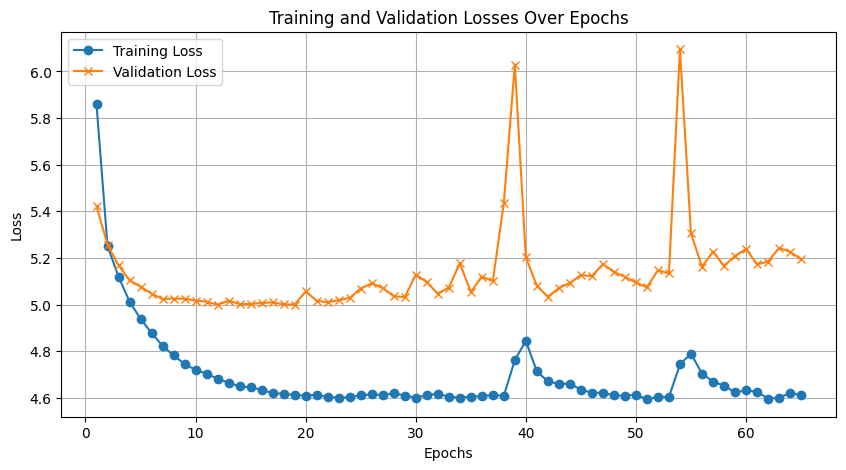

In [ ]:
epochs = list(range(1, 66))
plt.figure(figsize=(10, 5))
plt.plot(epochs, tr_loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='x')
plt.title('Training and Validation Losses Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
save_path = save_base_path + '{}_{}_{}.cp'.format(RUNNAME, 'final_model', '96_iterations')
torch.save(net,save_path)

In [ ]:
save_path = save_base_path + '{}_{}_{}.cp'.format(RUNNAME, 'entire_model', '101_iterations')


torch.save({'epoch': epoch,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr': lr}, save_path)

## 6. Look at outputs

In [ ]:
import matplotlib.pyplot as plt
import torch
from torchvision.transforms.functional import to_pil_image
from tqdm.notebook import tqdm

def visualize_segmentation_example_multilabel(net, test_data_loader):
    net.eval()  # Ensure the model is in evaluation mode.
    net.cuda()  # Ensure the model operates on the GPU.

    with torch.no_grad():  # Disable gradient computation for efficiency.
        # Iterating over the test dataset to get a single batch.
        for images, labels in tqdm(test_data_loader):

            images = images.cuda()

            # separate it out into the three labels
            label_built = labels[:, 0, :, :].unsqueeze(1)  # dimension as [batch_size, 1, height, width]
            label_pop = labels[:, 1, :, :].unsqueeze(1) # dimension as [batch_size, 1, height, width]
            label_lc = labels[:, 2, :, :] # dimension as [batch_size, height, width], i.e. removed the single dimension as cross entropy expects [batch size, height, width]

            # move them to GPU
            label_built = label_built.cuda()
            label_pop = label_pop.cuda()
            label_lc = label_lc.cuda()

            # Obtain the model's predictions.
            outputs = net(images) # [6, 25, 256, 256]
            outputs_built, outputs_pop, outputs_lc = process_outputs(outputs) # built & pop: [6, 1, 256, 256], lc: [6, 23, 256, 256]

            # Assuming the outputs of the classification task are raw logits, apply softmax to obtain probabilities.
            probs_lc = torch.softmax(outputs_lc, dim=1)

            # Convert probabilities to predicted class labels.
            predicted_masks_lc = torch.argmax(probs_lc, dim=1)

            # Move the tensors to the CPU for visualization.
            images, label_built, label_pop, label_lc, predicted_masks_lc = images.cpu(), label_built.cpu(), label_pop.cpu(), label_lc.cpu(), predicted_masks_lc.cpu()

            # Convert the first image and masks to PIL images for easy visualization.
            original_image_band1 = to_pil_image(images[0][0])
            original_image_band2 = to_pil_image(images[0][1])
            true_mask_built = to_pil_image(label_built[0].float())  # Adding channel dimension for compatibility.
            true_mask_pop = to_pil_image(label_pop[0].float())  # Adding channel dimension for compatibility.
            true_mask_lc = to_pil_image(label_lc[0].unsqueeze(0).float())  # Adding channel dimension for compatibility. # this could be an error, maybe leave the unsqueeze part away

            predicted_mask_built = to_pil_image(outputs_built[0])
            predicted_mask_pop = to_pil_image(outputs_pop[0])
            predicted_mask_lc = to_pil_image(predicted_masks_lc[0].unsqueeze(0).byte())

            # Visualization
            fig, ax = plt.subplots(2, 4, figsize=(20, 10))

            ax[0,0].imshow(original_image_band1)
            ax[0,0].set_title('Original Image Band 1')
            ax[0,0].axis('off')

            ax[1,0].imshow(original_image_band2) # second row, first column
            ax[1,0].set_title('Original Image Band 2')
            ax[1,0].axis('off')

            ax[0,1].imshow(true_mask_built)
            ax[0,1].set_title('True Mask BUILT')
            ax[0,1].axis('off')

            ax[1,1].imshow(predicted_mask_built)
            ax[1,1].set_title('Predicted Mask BUILT')
            ax[1,1].axis('off')

            ax[0,2].imshow(true_mask_pop)
            ax[0,2].set_title('True Mask POP')
            ax[0,2].axis('off')

            ax[1,2].imshow(predicted_mask_pop)
            ax[1,2].set_title('Predicted Mask POP')
            ax[1,2].axis('off')

            ax[0,3].imshow(true_mask_lc)
            ax[0,3].set_title('True Mask LC')
            ax[0,3].axis('off')

            ax[1,3].imshow(predicted_mask_lc)
            ax[1,3].set_title('Predicted Mask LC')
            ax[1,3].axis('off')

            plt.show()

            # Break after the first batch to only visualize one example.
            break
